In [1]:
#connet to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
sys.path.append('./gdrive/MyDrive/am220')

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from loader import *
from sklearn.model_selection import train_test_split
import tf_util
from matplotlib import pyplot as plt

In [4]:
resize = (150, 102)
#resize = (212, 144)

In [ ]:
%time
X, y = load('./gdrive/MyDrive/am220/data', resize=resize)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs
Processing 10th Image.
Processing 20th Image.
Processing 30th Image.
Processing 40th Image.
Processing 50th Image.
Processing 60th Image.
Processing 70th Image.
Processing 80th Image.
Processing 90th Image.
Processing 100th Image.
Processing 110th Image.
Processing 120th Image.
Processing 130th Image.
Processing 140th Image.
Processing 150th Image.
Processing 160th Image.


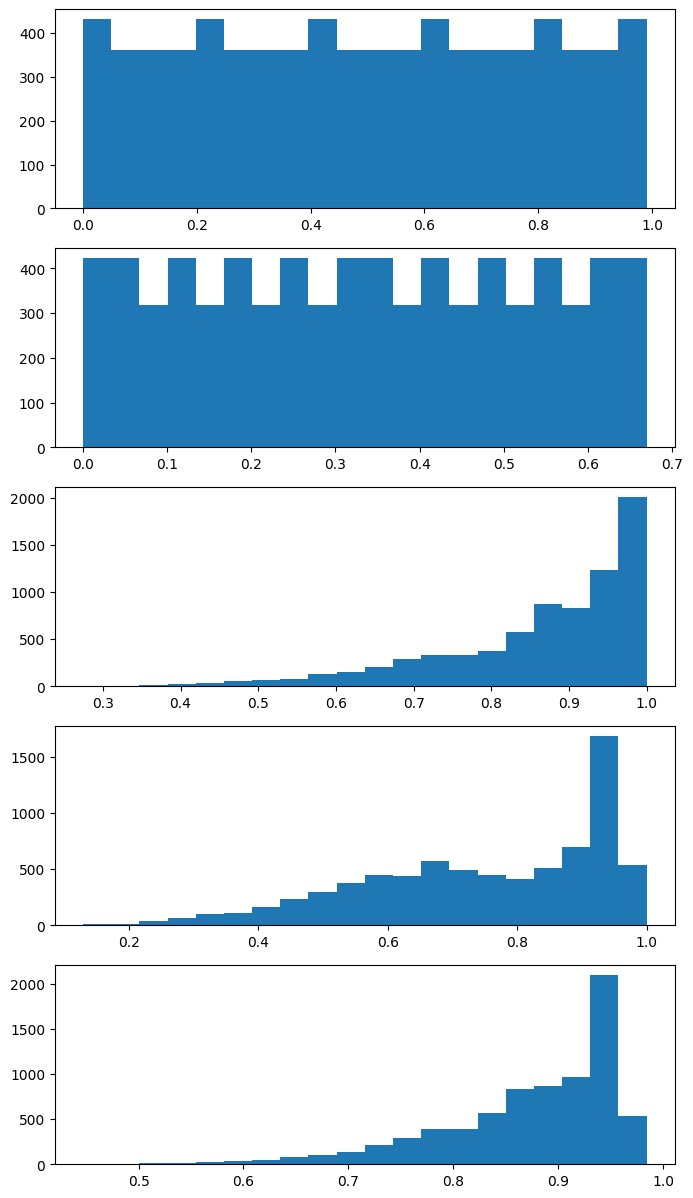

In [ ]:
##do some EDA
#plt.hist(X[0][:,0]);
fig, ax = plt.subplots(5, 1, figsize=(8, 15));
for i in range(5):
  ax[i].hist(X[2][:,i], bins=20);

The distribution of color rgb data is more clustered. This means that points will be more closed in terms of color then in terms of position. This may be bad because it makes the model favor color similarity then positional closeness.

__Approach1:__
The rgb color distributes in [0, 1], try to extend to [-1, 1] to increase the variance such that the color becomes less important.

__Approach2:__ standardize all colums

In [ ]:
##approach 1
# for i in range(X.shape[0]):
#   X[i][:, 2:] = 2*X[i][:, 2:] - 1

In [ ]:
#approach2
Means = X.reshape(-1, 5).mean(axis=0)
Standard = X.reshape(-1, 5).std(axis=0)

In [ ]:
##manually standardize
X[:, :, 0] = (X[:, :, 0]- Means[0])/Standard[0]
X[:, :, 1] = ((X[:, :, 1]- Means[1])/Standard[1])*resize[1]/resize[0]
X[:, :, 2] = (X[:, :, 2]- Means[2])/Standard[2]
X[:, :, 3] = (X[:, :, 3]- Means[3])/Standard[3]
X[:, :, 4] = (X[:, :, 4]- Means[4])/Standard[4]

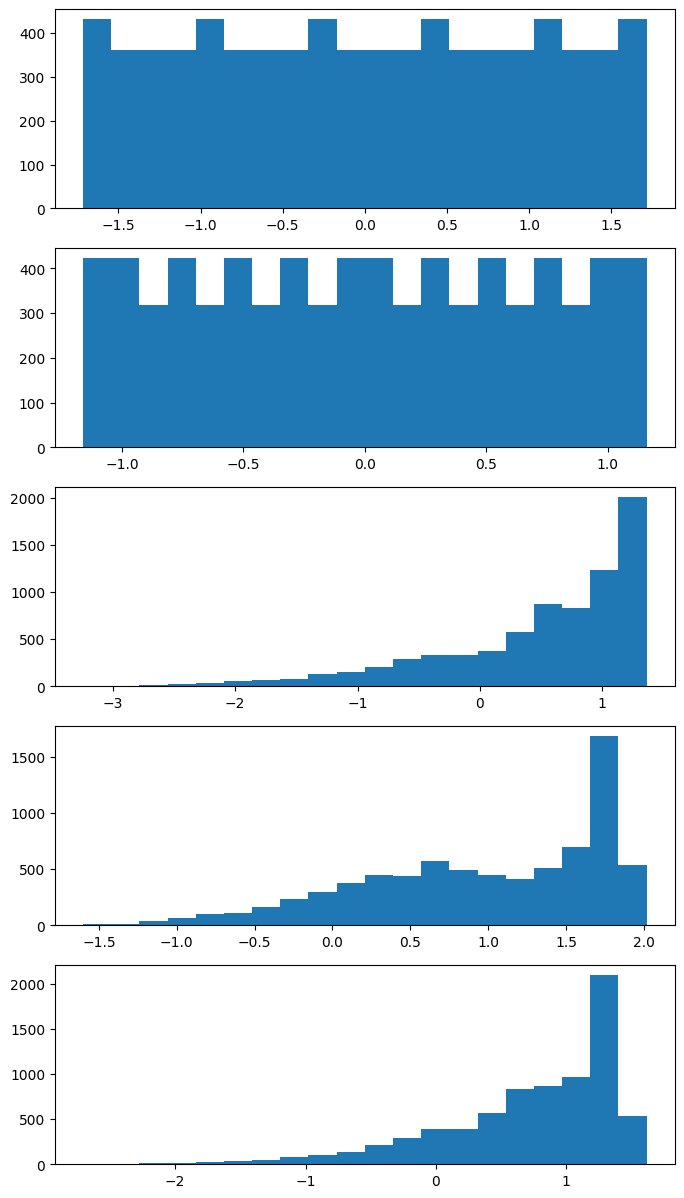

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(8, 15));
for i in range(5):
  ax[i].hist(X[2][:,i], bins=20);

In [ ]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
del X; del y

In [ ]:
# Define the batch size and number of batches
batch_size = 32
n_batches = len(X_train) // batch_size
# Create a TensorFlow Dataset object for the training data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# Shuffle the data and batch it
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)
# Create a TensorFlow Dataset object for the test data
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# Batch the data
test_dataset = test_dataset.batch(batch_size)

In [ ]:
del X_train, X_test, y_train, y_test

In [5]:
##define the knn layer
class knn(tf.keras.layers.Layer):
  def __init__(self, k):
    super().__init__()
    self.k = k

  def call(self, X):
    '''
    Parameters
    ==========
    inputs: Tensor of shape (N, d)

    Returns
    =======
    nn_idx: Tensor of shape (N, k)
      each row is the indices of the closest k points

    '''
    ##compute the adjacency matrix first
    point_cloud_transpose = tf.transpose(X, perm=[0, 2, 1])
    point_cloud_inner = tf.matmul(X, point_cloud_transpose)
    point_cloud_inner = -2*point_cloud_inner
    point_cloud_square = tf.reduce_sum(tf.square(X), axis=-1, keepdims=True)
    point_cloud_square_transpose = tf.transpose(point_cloud_square, perm=[0, 2, 1])
    adj = point_cloud_inner + point_cloud_square + point_cloud_square_transpose
    _, nn_idx = tf.nn.top_k(-adj, k=self.k)
    return nn_idx

##define the edge_feature layer
class Edge_Feature(tf.keras.layers.Layer):
  def __init__(self, nn_idx, k=20):
    super().__init__()
    self.nn_idx = nn_idx
    self.k = k

  def call(self, X):
    '''
    Parameters
    ==========
    point_cloud: tesor of shape (B, N, 5)

    Returns
    =======
    EdgeFeature: Tensor of shape (B, N, k, 10)

    '''
    batch_size = X.shape[0]
    num_points = X.shape[1]
    num_dims = X.shape[2]
    point_cloud_flat = tf.reshape(X, [-1, num_dims])
    idx_ = tf.range(batch_size) * num_points
    idx_ = tf.reshape(idx_, [batch_size, 1, 1])
    point_cloud_neighbors = tf.gather(point_cloud_flat, nn_idx+idx_)
  
    point_cloud_central = tf.expand_dims(X, axis=-2)
    point_cloud_central = tf.tile(point_cloud_central, [1, 1, self.k, 1])
    return point_cloud_neighbors

##define the costome conv2d layer
class conv2d(tf.keras.layers.Layer):
    def __init__(self, kernel_size, stride, num_output_channels, 
                 num_in_channels, padding="SAME", activation=tf.keras.layers.Activation('relu')):
        super().__init__()
        kernel_h, kernel_w = kernel_size
        self.activation = activation 
        self.stride = stride
        self.kernel_shape = [kernel_h, kernel_w, num_in_channels, num_output_channels]
        self.padding = padding
        ##initialize the kernel weights
        w_init = tf.keras.initializers.GlorotNormal()
        self.kernel = tf.Variable(
                    initial_value=w_init(shape=self.kernel_shape, dtype="float64"),
                    trainable=True)
        ##define bias variables
        self.biases  = tf.Variable(
                    initial_value=tf.constant_initializer(0.0)(shape=(num_output_channels), dtype="float64"),
                    trainable=True)
        
    def call(self, inputs):
        if inputs.dtype != tf.float64:
            inputs = tf.cast(inputs, tf.float64)
        outputs = tf.nn.conv2d(inputs, self.kernel,
                             [1, self.stride[1], self.stride[0], 1],
                             padding=self.padding)
        outputs = tf.nn.bias_add(outputs, self.biases)
        if self.activation is not None:
          outputs = self.activation(outputs)
        return outputs
        

In [6]:
##build the model
##define the input shape
N = int(resize[0]*resize[1]/4); hid_dim = 64; k =20
inputs = tf.keras.layers.Input(shape=(N, 5)) #(B, 3825, 5)
##compute the knn index
nn_idx = knn(k)(inputs) #(B, 3825, k)

##compute the edge features
batch_size = inputs.shape[0]
num_points = inputs.shape[1]
num_dims = inputs.shape[2]
point_cloud_flat = tf.reshape(inputs, [-1, num_dims]) # (5B, 3825)
point_cloud_neighbors = 0
if batch_size is not None:
    idx_ = tf.range(batch_size) * num_points
    idx_ = tf.reshape(idx_, [batch_size, 1, 1])
    point_cloud_neighbors = tf.gather(point_cloud_flat, nn_idx+idx_)
else: 
    point_cloud_neighbors = tf.gather(point_cloud_flat, nn_idx)
point_cloud_central = tf.expand_dims(inputs, axis=-2)
point_cloud_central = tf.tile(point_cloud_central, [1, 1, k, 1])
EdgeFeature = tf.concat([point_cloud_central, point_cloud_neighbors-point_cloud_central], axis=-1)

##go through first conv2d layer
out1 = conv2d(kernel_size=[1, 1], stride=[1,1], num_output_channels=hid_dim, 
       num_in_channels=EdgeFeature.shape[-1], padding="SAME")(EdgeFeature)
##one batch normalization 
out1 = tf.keras.layers.BatchNormalization()(out1)

##second conv2d layer
out2 = conv2d(kernel_size=[1, 1], stride=[1,1], num_output_channels=hid_dim, 
       num_in_channels=out1.shape[-1], padding="SAME")(out1)
##batch normalization 
out2 = tf.keras.layers.BatchNormalization()(out2)

##reduce max to update the point vector
net_1 = tf.reduce_max(out2, axis=-2, keepdims=True) #shape (B, N, 1, him_dim=64)
##reshape it into (B, N, hid_dim=64)
net_1_reshaped = tf.keras.layers.Reshape(target_shape=(N, hid_dim), dtype=tf.float64)(net_1)

##go throught the second EdgeConv layer
##compute the knn index
nn_idx = knn(k)(net_1_reshaped)
##compute the edge features
num_dims = hid_dim
point_cloud_flat = tf.reshape(net_1_reshaped, [-1, num_dims])
point_cloud_neighbors = 0
if batch_size is not None:
    idx_ = tf.range(batch_size) * num_points
    idx_ = tf.reshape(idx_, [batch_size, 1, 1])
    point_cloud_neighbors = tf.gather(point_cloud_flat, nn_idx+idx_)
else: 
    point_cloud_neighbors = tf.gather(point_cloud_flat, nn_idx)
point_cloud_central = tf.expand_dims(net_1_reshaped, axis=-2)
point_cloud_central = tf.tile(point_cloud_central, [1, 1, k, 1])
EdgeFeature = tf.concat([point_cloud_central, point_cloud_neighbors-point_cloud_central], axis=-1)
##go through first conv2d layer
out3 = conv2d(kernel_size=[1, 1], stride=[1,1], num_output_channels=hid_dim, 
       num_in_channels=EdgeFeature.shape[-1], padding="SAME")(EdgeFeature)
##one batch normalization 
out3 = tf.keras.layers.BatchNormalization()(out3)
##second conv2d layer
out4 = conv2d(kernel_size=[1, 1], stride=[1,1], num_output_channels=hid_dim, 
       num_in_channels=out3.shape[-1], padding="SAME")(out3)
##batch normalization 
out4 = tf.keras.layers.BatchNormalization()(out4)

##reduce max to update the point vector
net_2 = tf.reduce_max(out4, axis=-2, keepdims=True) #shape (B, N, 1, him_dim=64)
##reshape it into (B, N, hid_dim=64)
net_2_reshaped = tf.keras.layers.Reshape(target_shape=(N, hid_dim), dtype=tf.float64)(net_2)

#third EdgeConv layer
##compute the knn index
nn_idx = knn(k)(net_2_reshaped)
##compute the edge features
point_cloud_flat = tf.reshape(net_2_reshaped, [-1, num_dims])
point_cloud_neighbors = 0
if batch_size is not None:
    idx_ = tf.range(batch_size) * num_points
    idx_ = tf.reshape(idx_, [batch_size, 1, 1])
    point_cloud_neighbors = tf.gather(point_cloud_flat, nn_idx+idx_)
else: 
    point_cloud_neighbors = tf.gather(point_cloud_flat, nn_idx)
point_cloud_central = tf.expand_dims(net_2_reshaped, axis=-2)
point_cloud_central = tf.tile(point_cloud_central, [1, 1, k, 1])
EdgeFeature = tf.concat([point_cloud_central, point_cloud_neighbors-point_cloud_central], axis=-1)
##go through first conv2d layer
out5 = conv2d(kernel_size=[1, 1], stride=[1,1], num_output_channels=hid_dim, 
       num_in_channels=EdgeFeature.shape[-1], padding="SAME")(EdgeFeature)
##one batch normalization 
out5 = tf.keras.layers.BatchNormalization()(out5)
##reduce max to update the point vector
net_3 = tf.reduce_max(out5, axis=-2, keepdims=True) #shape (B, N, 1, him_dim=64)

##another 2d convolutional layer
out7 = conv2d(kernel_size=[1, 1], stride=[1, 1], num_output_channels=1024,
              num_in_channels=net_3.shape[-1], padding="SAME")(net_3)
##batch normalization 
out7 = tf.keras.layers.BatchNormalization()(out7)

##max-pooling
out_max = tf_util.max_pool2d(out7, [N, 1], padding='VALID', scope='maxpool')
expand = tf.tile(out_max, [1, N, 1, 1])

##concatenate
concat = tf.concat(axis=3, values=[expand, net_1, net_2, net_3])

##final fully connected layers
net = conv2d(kernel_size=[1, 1], stride=[1, 1], num_output_channels=512, 
      num_in_channels=concat.shape[-1], padding="VALID")(concat)
net = tf.keras.layers.BatchNormalization()(net)
net = conv2d(kernel_size=[1, 1], stride=[1, 1], num_output_channels=256, 
      num_in_channels=net.shape[-1], padding="VALID")(net)
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Dropout(0.3)(net)
##get the logits
net = conv2d(kernel_size=[1, 1], stride=[1, 1], num_output_channels=1, 
      num_in_channels=net.shape[-1], padding="VALID", activation = tf.keras.activations.sigmoid)(net)
net = tf.squeeze(net, [2])
net = tf.squeeze(net, axis=-1)

model = tf.keras.Model(inputs=inputs, outputs = net)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3825, 5)]    0           []                               
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 3825, 1, 5)   0           ['input_1[0][0]']                
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 5)            0           ['input_1[0][0]']                
                                                                                                  
 knn (knn)                      (None, 3825, 20)     0           ['input_1[0][0]']                
                                                                                              

## Define the functions to measure the outputs

In [ ]:
##define custome accuracy function 
def accuracy(y_true, y_pred):
  n = y_pred.numpy().shape[0] * y_pred.numpy().shape[1]
  right = ((y_pred.numpy() > 0.5)*1 == y_true.numpy()).sum()
  return right/n

##compute IoU = overlap / union
def IoU(y_true, y_pred):
  y_true = y_true.numpy()
  y_pred = (y_pred.numpy()>0.5)*1
  overlap = (y_true * y_pred).sum()
  union = (((y_true + y_pred) > 0)*1).sum()
  return overlap/union

##compute DICE = 2*overlap/ areaA + areaB
def DICE(y_true, y_pred):
  y_true = y_true.numpy()
  y_pred = (y_pred.numpy()>0.5)*1
  overlap = (y_true * y_pred).sum()
  areaA = y_true.sum()
  areaB = y_pred.sum()
  return overlap/(areaA + areaB)

In [ ]:
##this function computes the average accuracy over batch
def avg_accuracy(model, data):
  accu = 0
  count = 0
  for X, y in data:
    output = model(X)
    accu += accuracy(y, output)
    count+= 1
  return accu/count

In [ ]:
def plot_result(pred, y, X, save=None, show_label=True):
  #pred and y should both be numpy 1d array of size N
  #X is a numpy 2darray of shape (N, 5)
  r = X[:, 2:][:,0].reshape(int(resize[1]/2), int(resize[0]/2))
  g = X[:, 2:][:,1].reshape(int(resize[1]/2), int(resize[0]/2))
  b = X[:, 2:][:,2].reshape(int(resize[1]/2), int(resize[0]/2))
  rgb = np.dstack((r,g,b))
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  ax[0].imshow(rgb, zorder=0)
  if show_label:
    ax[0].imshow(y.reshape(int(resize[1]/2), int(resize[0]/2)), alpha=.5)
  ax[0].axis('off')
  ax[0].set_title("Image and True Label");
  ax[1].imshow(pred.reshape(int(resize[1]/2), int(resize[0]/2)))
  ax[1].axis('off')
  ax[1].set_title("Predicted Label");
  if save is not None:
    plt.savefig(save, dpi=200)

In [ ]:
##this function computes the average IoU over batches
def avg_IoU(model, data):
  iou = 0
  count = 0
  for X, y in data:
    count += 1
    output = model(X)
    iou += IoU(y, output)
  return iou/count

##this function computes the average DICE over batches
def avg_DICE(model, data):
  dice = 0
  count = 0
  for X, y in data:
    count += 1
    output = model(X)
    dice += DICE(y, output)
  return dice/count

In [ ]:
##this function is a callback function that computes the model's IoU over train 
#and appends to a container
def IoUDecorator(model, dataset, text, every_epoch=5):
  def inner(epoch, _):
    if (epoch % every_epoch) != 0:
      return
    ##compute the overall iou
    overall_iou = avg_IoU(model, dataset)
    print("{}: {}".format(text, overall_iou))
    if text not in model.history.history.keys():
      model.history.history[text] = []
    model.history.history[text].append(overall_iou)
  return inner
  
def DiceDecorator(model, dataset, text, every_epoch=5):
  def inner(epoch, _):
    if (epoch % every_epoch) != 0:
      return
    ##compute the overall dice
    overall_dice = avg_DICE(model, dataset)
    print("{}: {}".format(text, overall_dice))
    if text not in model.history.history.keys():
          model.history.history[text] = []
    model.history.history[text].append(overall_dice)
  return inner



## Define a Callback Function that plots the evolution of the prediction over epochs

In [ ]:
##get one sample of the test Image
##X_test and y_test are one batch of the test images
X_test, y_test = list(test_dataset.take(1))[0]

In [ ]:
##let's take this image as the sample of evolution
index = 14
#plot_result((y_pred_test[index].numpy() > 0.5)*1, y_test[index].numpy(), X_test[index].numpy())

In [ ]:
##this function gives you the usable individual image in the batch that be fed to the model directly
##and its label both are returned as numpy array
def get_sample(index, batch_X, batch_y):
  return np.array([batch_X[index].numpy()]), batch_y[index].numpy()

def evolutionDecorator(index, batch_X, batch_y, model, every_epoch=5):
  X, y = get_sample(index, batch_X, batch_y)
  def inner(epoch, _):
    if (epoch % every_epoch) != 0:
      return
    print("Plotting prediction on {} epoch".format(epoch+1))
    #get the prediction
    pred = (model(X).numpy()[0] > 0.5)*1
    plot_result(pred, y, X[0])
    plt.show()
  return inner

evolution_index14 = evolutionDecorator(14, X_test, y_test, model, every_epoch=5)

## Compile and Train the model

In [ ]:
##load the model if necessary
#model.load_weights("./gdrive/MyDrive/am220/dgcnn_checkpoint")

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False))

In [ ]:
cp = tf.keras.callbacks.ModelCheckpoint(
    "./gdrive/MyDrive/am220/dgcnn_checkpointK_k15_B32_H32_lr1e-4_100epochs_N212-144-standardized",
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = "auto",
    save_freq="epoch",
)

In [ ]:
##define lambda callback
every = 2
trainiou = IoUDecorator(model, train_dataset, "train_iou", every_epoch=every)
testiou = IoUDecorator(model, test_dataset, "test_iou", every_epoch=every)
trainiou_cbk = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: 
                      trainiou(epoch, _))
testiou_cbk = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: 
                      testiou(epoch, _))
evolution_cbk = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs:
                                                  evolution_index14(epoch, _))

Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 0.8940train_iou: 0.08988022040975896
test_iou: 0.08917010449662692
Plotting prediction on 1 epoch


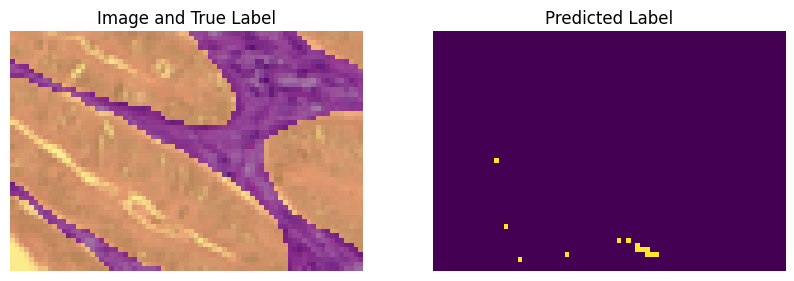

Plotting prediction on 1 epoch


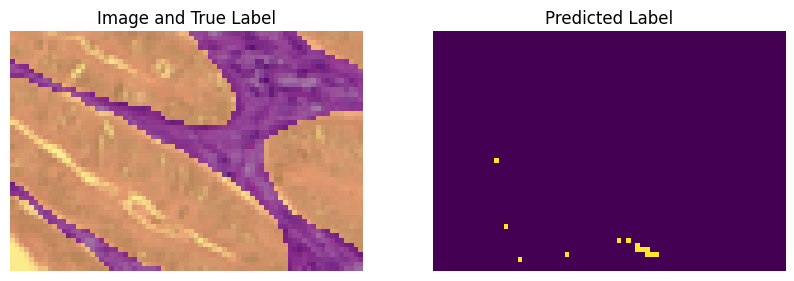

17/17 [==============================] - 30s 996ms/step - loss: 0.8940 - val_loss: 0.6939
Epoch 2/100
17/17 [==============================] - 7s 436ms/step - loss: 0.8205 - val_loss: 0.7300
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 0.7718train_iou: 0.0
test_iou: 0.0
17/17 [==============================] - 11s 687ms/step - loss: 0.7718 - val_loss: 0.7673
Epoch 4/100
17/17 [==============================] - 7s 435ms/step - loss: 0.7549 - val_loss: 0.8555
Epoch 5/100
17/17 [==============================] - ETA: 0s - loss: 0.7479train_iou: 0.0
test_iou: 0.0
17/17 [==============================] - 11s 686ms/step - loss: 0.7479 - val_loss: 0.7969
Epoch 6/100
17/17 [==============================] - ETA: 0s - loss: 0.7312Plotting prediction on 6 epoch


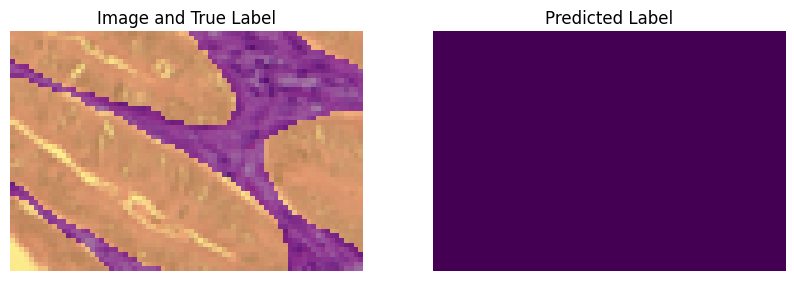

Plotting prediction on 6 epoch


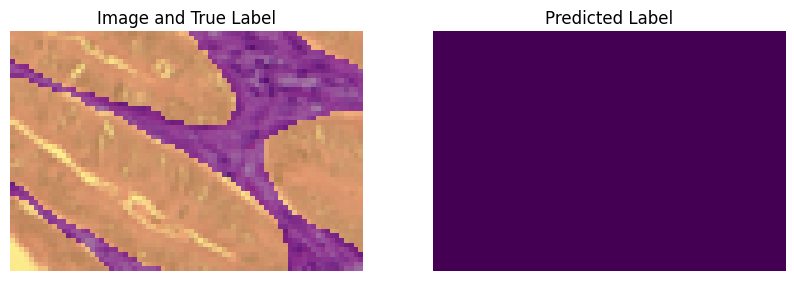

17/17 [==============================] - 8s 472ms/step - loss: 0.7312 - val_loss: 0.8786
Epoch 7/100
17/17 [==============================] - ETA: 0s - loss: 0.7450train_iou: 0.0
test_iou: 0.0
17/17 [==============================] - 11s 687ms/step - loss: 0.7450 - val_loss: 0.8626
Epoch 8/100
17/17 [==============================] - 7s 435ms/step - loss: 0.7273 - val_loss: 0.8891
Epoch 9/100
17/17 [==============================] - ETA: 0s - loss: 0.7100train_iou: 0.0
test_iou: 0.0
17/17 [==============================] - 11s 686ms/step - loss: 0.7100 - val_loss: 0.8167
Epoch 10/100
17/17 [==============================] - 7s 436ms/step - loss: 0.7099 - val_loss: 0.7996
Epoch 11/100
17/17 [==============================] - ETA: 0s - loss: 0.6985train_iou: 0.2853991993409629
test_iou: 0.25215420681710343
Plotting prediction on 11 epoch


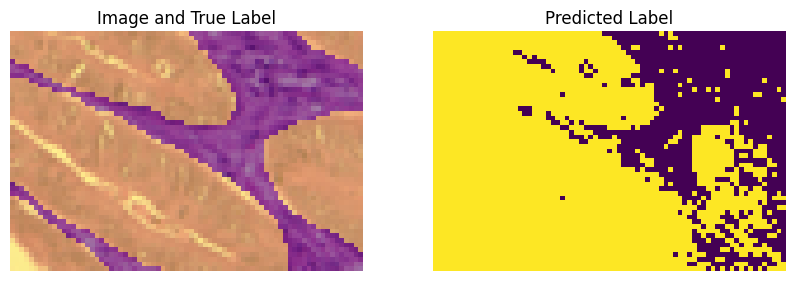

Plotting prediction on 11 epoch


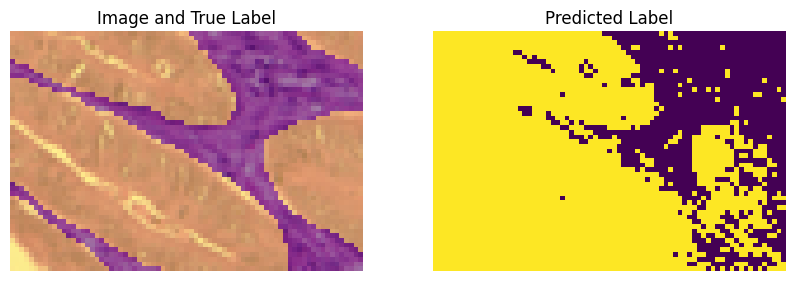

17/17 [==============================] - 12s 709ms/step - loss: 0.6985 - val_loss: 0.7002
Epoch 12/100
17/17 [==============================] - 7s 436ms/step - loss: 0.7040 - val_loss: 0.7512
Epoch 13/100
17/17 [==============================] - ETA: 0s - loss: 0.6956train_iou: 0.2796889147103427
test_iou: 0.2847290376821316
17/17 [==============================] - 11s 686ms/step - loss: 0.6956 - val_loss: 0.7014
Epoch 14/100
17/17 [==============================] - 7s 435ms/step - loss: 0.6944 - val_loss: 0.6849
Epoch 15/100
17/17 [==============================] - ETA: 0s - loss: 0.6925train_iou: 0.5244019580672521
test_iou: 0.5833215136440165
17/17 [==============================] - 11s 686ms/step - loss: 0.6925 - val_loss: 0.7253
Epoch 16/100
17/17 [==============================] - ETA: 0s - loss: 0.6746Plotting prediction on 16 epoch


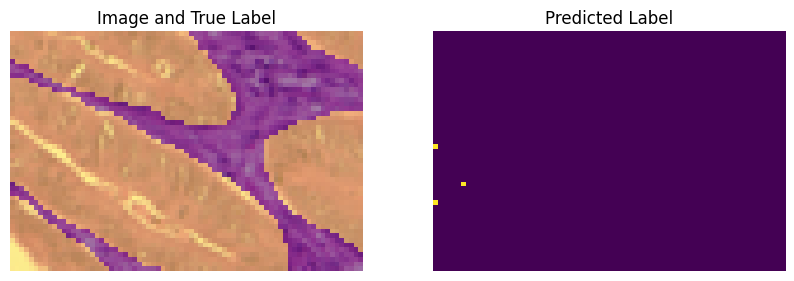

Plotting prediction on 16 epoch


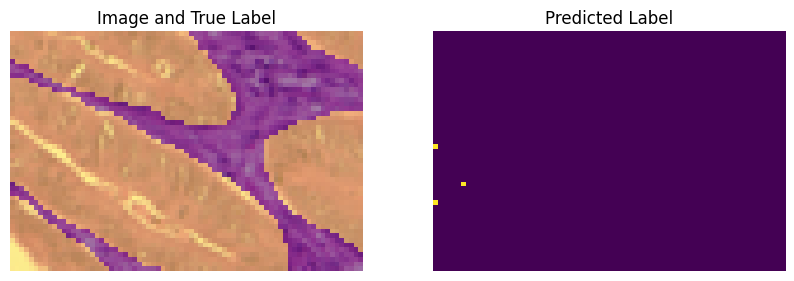

17/17 [==============================] - 8s 458ms/step - loss: 0.6746 - val_loss: 0.6834
Epoch 17/100
17/17 [==============================] - ETA: 0s - loss: 0.6743train_iou: 0.41043733145496564
test_iou: 0.39060872565339294
17/17 [==============================] - 11s 684ms/step - loss: 0.6743 - val_loss: 0.6918
Epoch 18/100
17/17 [==============================] - 7s 435ms/step - loss: 0.6846 - val_loss: 0.7661
Epoch 19/100
17/17 [==============================] - ETA: 0s - loss: 0.6809train_iou: 0.5257721194625601
test_iou: 0.5873361210315867
17/17 [==============================] - 11s 686ms/step - loss: 0.6809 - val_loss: 0.7580
Epoch 20/100
17/17 [==============================] - 7s 436ms/step - loss: 0.6728 - val_loss: 0.7286
Epoch 21/100
17/17 [==============================] - ETA: 0s - loss: 0.6609train_iou: 0.5203373466940716
test_iou: 0.5882248114250387
Plotting prediction on 21 epoch


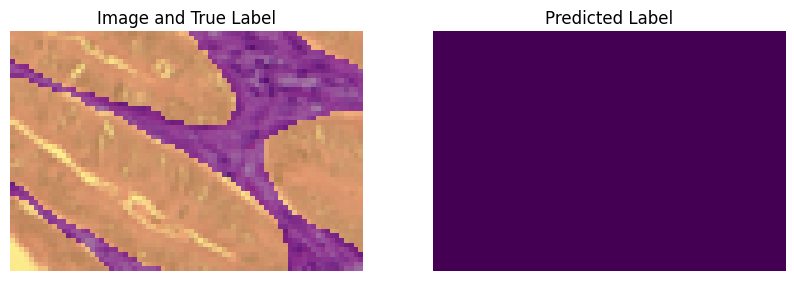

Plotting prediction on 21 epoch


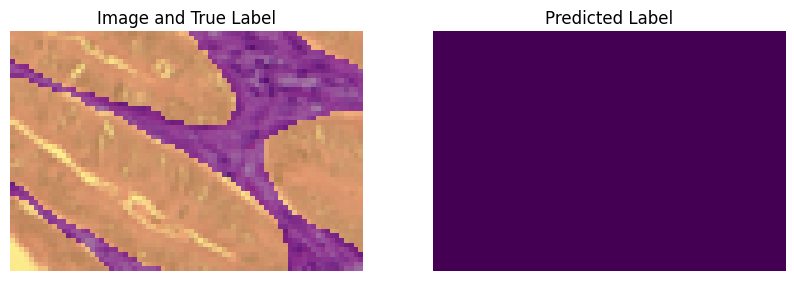

17/17 [==============================] - 12s 710ms/step - loss: 0.6609 - val_loss: 0.8013
Epoch 22/100
17/17 [==============================] - 7s 435ms/step - loss: 0.6618 - val_loss: 0.7313
Epoch 23/100
17/17 [==============================] - ETA: 0s - loss: 0.6640train_iou: 0.5168112629698709
test_iou: 0.5670326751676027
17/17 [==============================] - 11s 686ms/step - loss: 0.6640 - val_loss: 0.7200
Epoch 24/100
17/17 [==============================] - 7s 435ms/step - loss: 0.6555 - val_loss: 0.7527
Epoch 25/100
17/17 [==============================] - ETA: 0s - loss: 0.6576train_iou: 0.5224569843093982
test_iou: 0.5802771151535622
17/17 [==============================] - 11s 685ms/step - loss: 0.6576 - val_loss: 0.7527
Epoch 26/100
17/17 [==============================] - ETA: 0s - loss: 0.6536Plotting prediction on 26 epoch


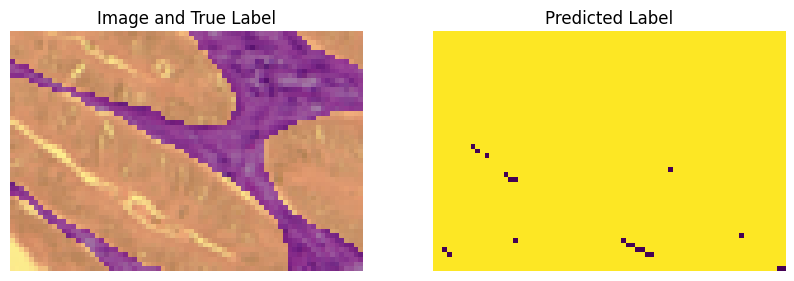

Plotting prediction on 26 epoch


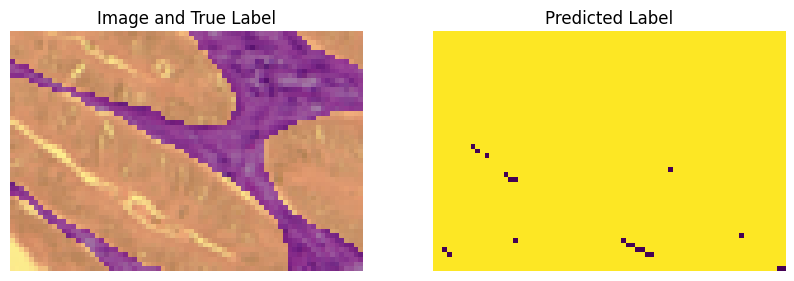

17/17 [==============================] - 8s 458ms/step - loss: 0.6536 - val_loss: 0.7909
Epoch 27/100
17/17 [==============================] - ETA: 0s - loss: 0.6562train_iou: 0.5245445670502976
test_iou: 0.5815498358225737
17/17 [==============================] - 11s 686ms/step - loss: 0.6562 - val_loss: 0.8043
Epoch 28/100
17/17 [==============================] - 7s 435ms/step - loss: 0.6530 - val_loss: 0.8598
Epoch 29/100
17/17 [==============================] - ETA: 0s - loss: 0.6505train_iou: 0.5254632003502908
test_iou: 0.5453645855558975
17/17 [==============================] - 11s 686ms/step - loss: 0.6505 - val_loss: 0.7107
Epoch 30/100
17/17 [==============================] - 7s 435ms/step - loss: 0.6439 - val_loss: 0.7499
Epoch 31/100
17/17 [==============================] - ETA: 0s - loss: 0.6504train_iou: 0.5109905979504311
test_iou: 0.5250876582205222
Plotting prediction on 31 epoch


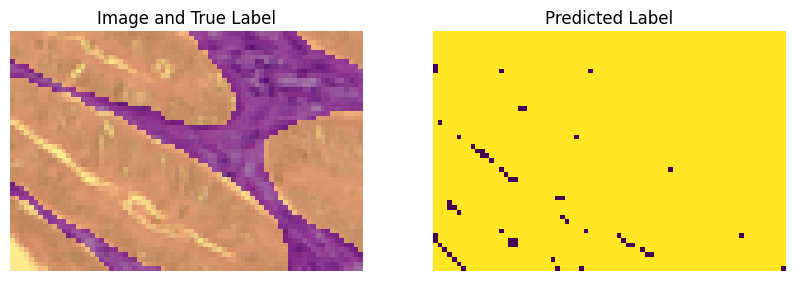

Plotting prediction on 31 epoch


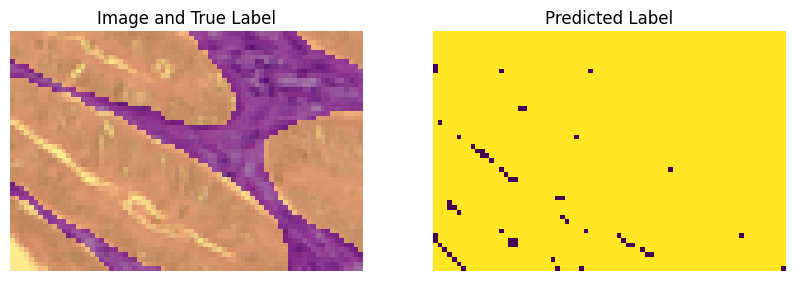

17/17 [==============================] - 12s 706ms/step - loss: 0.6504 - val_loss: 0.7018
Epoch 32/100
17/17 [==============================] - 7s 435ms/step - loss: 0.6449 - val_loss: 0.7225
Epoch 33/100
17/17 [==============================] - ETA: 0s - loss: 0.6359train_iou: 0.44483295540001655
test_iou: 0.42141097475627165
17/17 [==============================] - 11s 686ms/step - loss: 0.6359 - val_loss: 0.7290
Epoch 34/100
17/17 [==============================] - 7s 435ms/step - loss: 0.6468 - val_loss: 0.6867
Epoch 35/100
17/17 [==============================] - ETA: 0s - loss: 0.6387train_iou: 0.5263486471859175
test_iou: 0.5221296915515687
17/17 [==============================] - 11s 685ms/step - loss: 0.6387 - val_loss: 0.6850
Epoch 36/100
17/17 [==============================] - ETA: 0s - loss: 0.6325Plotting prediction on 36 epoch


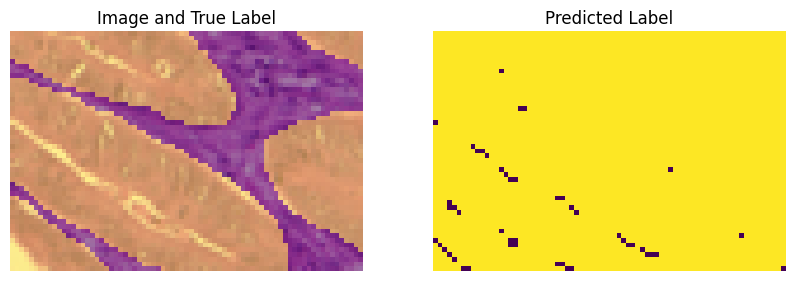

Plotting prediction on 36 epoch


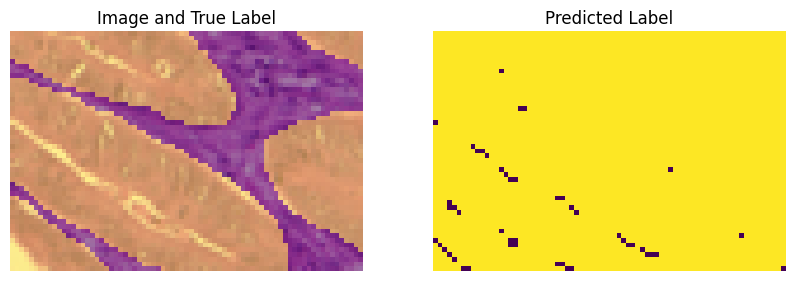

17/17 [==============================] - 8s 458ms/step - loss: 0.6325 - val_loss: 0.7796
Epoch 37/100
17/17 [==============================] - ETA: 0s - loss: 0.6252train_iou: 0.5257416738053061
test_iou: 0.4925721625326502
17/17 [==============================] - 11s 684ms/step - loss: 0.6252 - val_loss: 0.6888
Epoch 38/100
17/17 [==============================] - 7s 436ms/step - loss: 0.6178 - val_loss: 0.6924
Epoch 39/100
17/17 [==============================] - ETA: 0s - loss: 0.6281train_iou: 0.5327835909968242
test_iou: 0.5442391072000022
17/17 [==============================] - 11s 685ms/step - loss: 0.6281 - val_loss: 0.7130
Epoch 40/100
17/17 [==============================] - 7s 435ms/step - loss: 0.6294 - val_loss: 0.7396
Epoch 41/100
17/17 [==============================] - ETA: 0s - loss: 0.6247train_iou: 0.5445839100779166
test_iou: 0.5529722393558448
Plotting prediction on 41 epoch


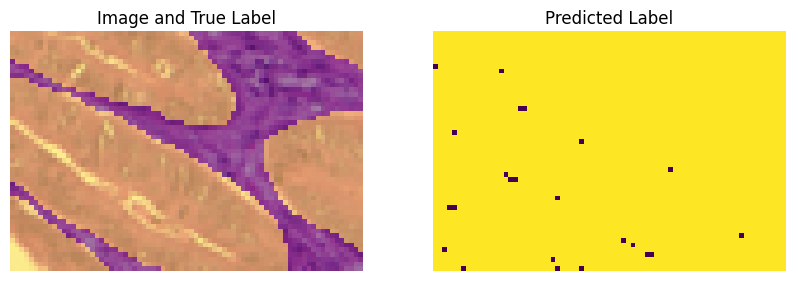

Plotting prediction on 41 epoch


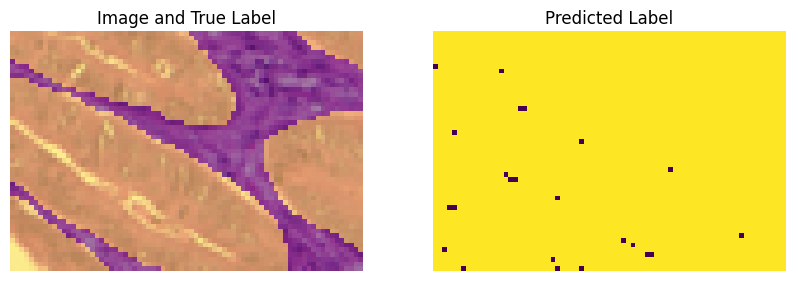

17/17 [==============================] - 12s 709ms/step - loss: 0.6247 - val_loss: 0.7286
Epoch 42/100
17/17 [==============================] - 7s 435ms/step - loss: 0.6239 - val_loss: 0.7468
Epoch 43/100
17/17 [==============================] - ETA: 0s - loss: 0.6091train_iou: 0.5385947612183618
test_iou: 0.5237207988409631
17/17 [==============================] - 11s 685ms/step - loss: 0.6091 - val_loss: 0.6829
Epoch 44/100
17/17 [==============================] - 7s 435ms/step - loss: 0.6154 - val_loss: 0.6802
Epoch 45/100
17/17 [==============================] - ETA: 0s - loss: 0.6083train_iou: 0.5473269139125824
test_iou: 0.5461391211081656
17/17 [==============================] - 11s 686ms/step - loss: 0.6083 - val_loss: 0.7086
Epoch 46/100
17/17 [==============================] - ETA: 0s - loss: 0.6078Plotting prediction on 46 epoch


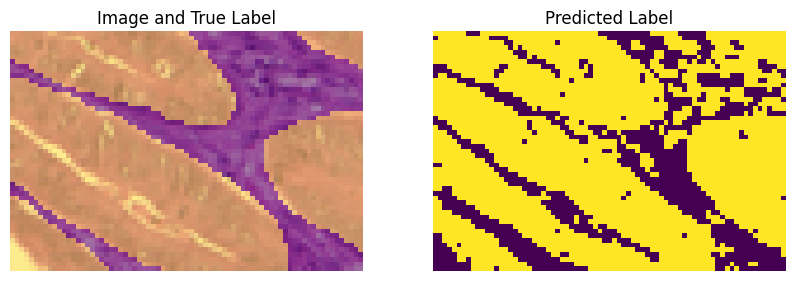

Plotting prediction on 46 epoch


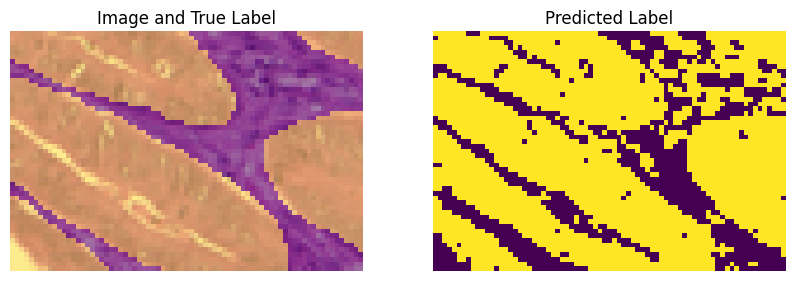

17/17 [==============================] - 8s 459ms/step - loss: 0.6078 - val_loss: 0.7004
Epoch 47/100
17/17 [==============================] - ETA: 0s - loss: 0.6160train_iou: 0.5722026725354078
test_iou: 0.5460645999607501
17/17 [==============================] - 11s 685ms/step - loss: 0.6160 - val_loss: 0.6815
Epoch 48/100
17/17 [==============================] - 7s 435ms/step - loss: 0.6104 - val_loss: 0.6764
Epoch 49/100
17/17 [==============================] - ETA: 0s - loss: 0.6191train_iou: 0.35487468546309286
test_iou: 0.3764130653332168
17/17 [==============================] - 11s 685ms/step - loss: 0.6191 - val_loss: 0.7059
Epoch 50/100
17/17 [==============================] - 7s 435ms/step - loss: 0.6050 - val_loss: 0.7101
Epoch 51/100
17/17 [==============================] - ETA: 0s - loss: 0.6029train_iou: 0.3877394796994576
test_iou: 0.3849805464123147
Plotting prediction on 51 epoch


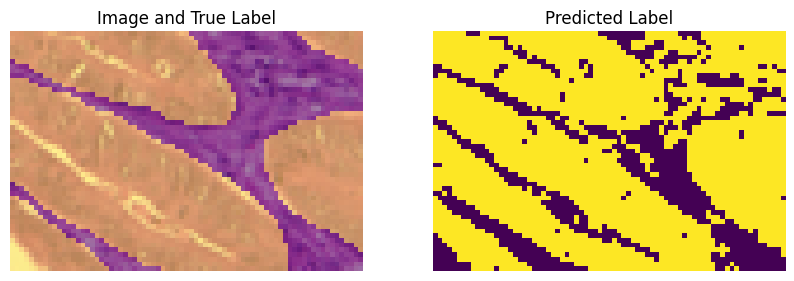

Plotting prediction on 51 epoch


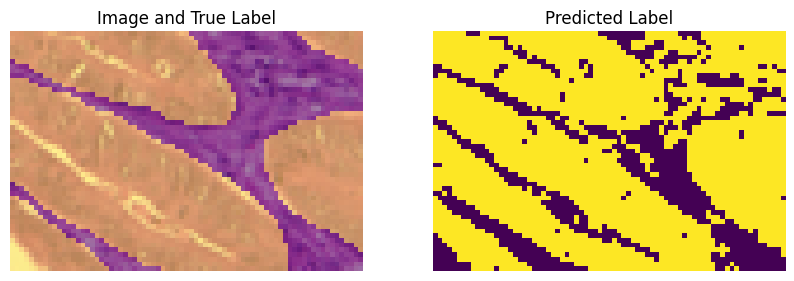

17/17 [==============================] - 12s 707ms/step - loss: 0.6029 - val_loss: 0.7169
Epoch 52/100
17/17 [==============================] - 7s 435ms/step - loss: 0.6114 - val_loss: 0.7117
Epoch 53/100
17/17 [==============================] - ETA: 0s - loss: 0.6035train_iou: 0.561474014061417
test_iou: 0.5400030646649625
17/17 [==============================] - 11s 685ms/step - loss: 0.6035 - val_loss: 0.6469
Epoch 54/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5942 - val_loss: 0.6630
Epoch 55/100
17/17 [==============================] - ETA: 0s - loss: 0.5962train_iou: 0.5179377554590016
test_iou: 0.4985547300291387
17/17 [==============================] - 11s 684ms/step - loss: 0.5962 - val_loss: 0.6469
Epoch 56/100
17/17 [==============================] - ETA: 0s - loss: 0.6007Plotting prediction on 56 epoch


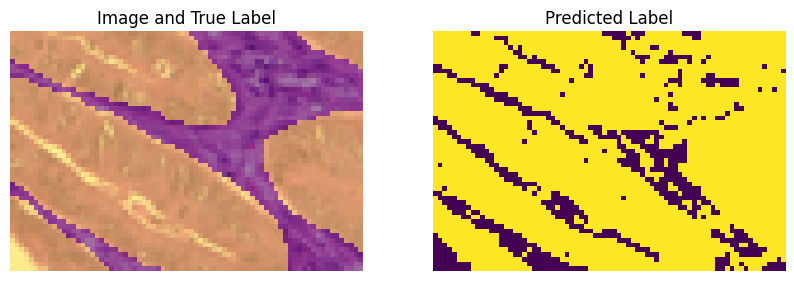

Plotting prediction on 56 epoch


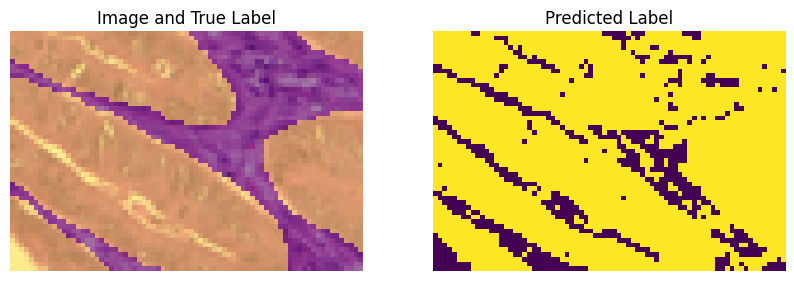

17/17 [==============================] - 8s 458ms/step - loss: 0.6007 - val_loss: 0.6551
Epoch 57/100
17/17 [==============================] - ETA: 0s - loss: 0.6028train_iou: 0.5049811372020167
test_iou: 0.546437502862983
17/17 [==============================] - 11s 684ms/step - loss: 0.6028 - val_loss: 0.6408
Epoch 58/100
17/17 [==============================] - 7s 436ms/step - loss: 0.5931 - val_loss: 0.6786
Epoch 59/100
17/17 [==============================] - ETA: 0s - loss: 0.5884train_iou: 0.42005490730554795
test_iou: 0.45190823242341366
17/17 [==============================] - 11s 685ms/step - loss: 0.5884 - val_loss: 0.6506
Epoch 60/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5956 - val_loss: 0.6392
Epoch 61/100
17/17 [==============================] - ETA: 0s - loss: 0.5883train_iou: 0.4729234876049698
test_iou: 0.45047301720229405
Plotting prediction on 61 epoch


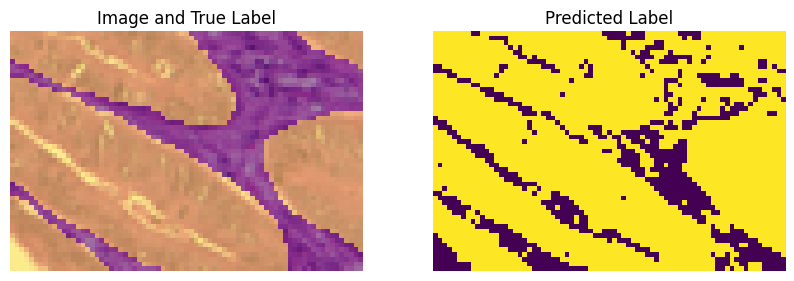

Plotting prediction on 61 epoch


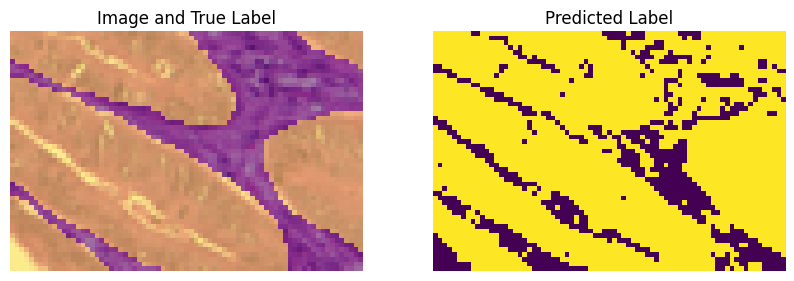

17/17 [==============================] - 12s 709ms/step - loss: 0.5883 - val_loss: 0.6536
Epoch 62/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5894 - val_loss: 0.6675
Epoch 63/100
17/17 [==============================] - ETA: 0s - loss: 0.5764train_iou: 0.4652721495704963
test_iou: 0.4958697434874907
17/17 [==============================] - 11s 685ms/step - loss: 0.5764 - val_loss: 0.6632
Epoch 64/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5850 - val_loss: 0.7620
Epoch 65/100
17/17 [==============================] - ETA: 0s - loss: 0.5849train_iou: 0.5425654423071555
test_iou: 0.5494037471614932
17/17 [==============================] - 11s 685ms/step - loss: 0.5849 - val_loss: 0.7171
Epoch 66/100
17/17 [==============================] - ETA: 0s - loss: 0.5714Plotting prediction on 66 epoch


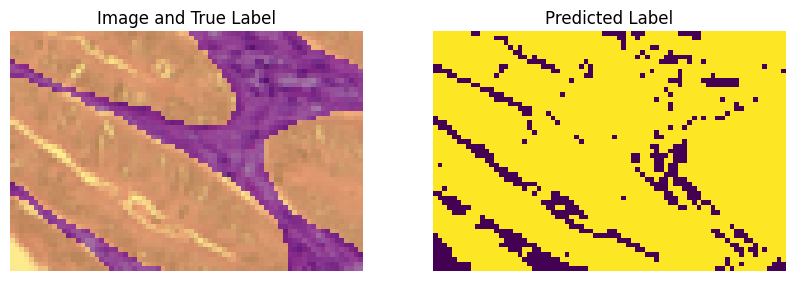

Plotting prediction on 66 epoch


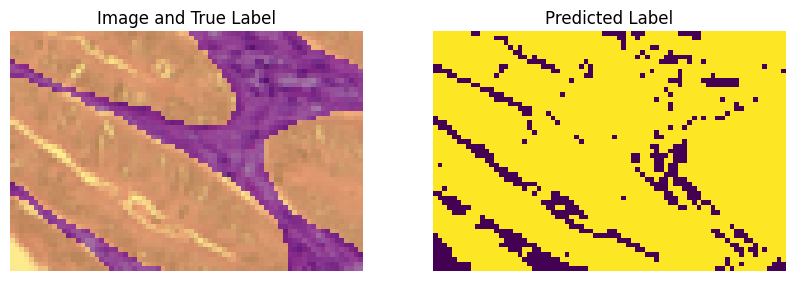

17/17 [==============================] - 8s 458ms/step - loss: 0.5714 - val_loss: 0.6942
Epoch 67/100
17/17 [==============================] - ETA: 0s - loss: 0.5729train_iou: 0.3904316857164889
test_iou: 0.43215047951025476
17/17 [==============================] - 11s 685ms/step - loss: 0.5729 - val_loss: 0.6951
Epoch 68/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5716 - val_loss: 0.6770
Epoch 69/100
17/17 [==============================] - ETA: 0s - loss: 0.5831train_iou: 0.3762845797118095
test_iou: 0.3734896335111835
17/17 [==============================] - 11s 685ms/step - loss: 0.5831 - val_loss: 0.7312
Epoch 70/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5777 - val_loss: 0.7555
Epoch 71/100
17/17 [==============================] - ETA: 0s - loss: 0.5670train_iou: 0.5691497085677243
test_iou: 0.5539343311266037
Plotting prediction on 71 epoch


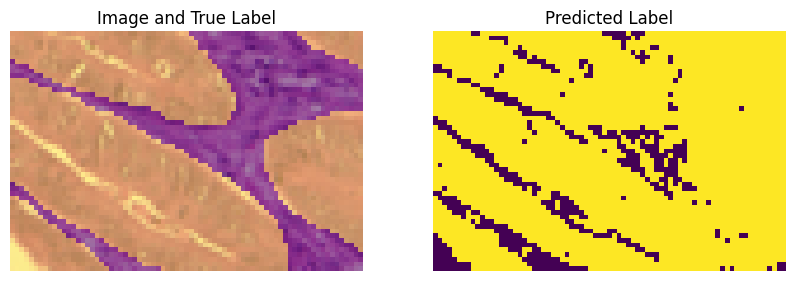

Plotting prediction on 71 epoch


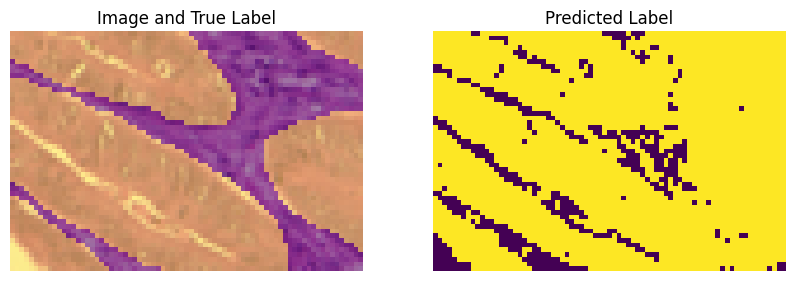

17/17 [==============================] - 12s 709ms/step - loss: 0.5670 - val_loss: 0.6745
Epoch 72/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5681 - val_loss: 0.6630
Epoch 73/100
17/17 [==============================] - ETA: 0s - loss: 0.5730train_iou: 0.5423456259059977
test_iou: 0.5596671836324963
17/17 [==============================] - 11s 685ms/step - loss: 0.5730 - val_loss: 0.7298
Epoch 74/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5637 - val_loss: 0.6970
Epoch 75/100
17/17 [==============================] - ETA: 0s - loss: 0.5771train_iou: 0.4646181854152236
test_iou: 0.41192846364340346
17/17 [==============================] - 11s 684ms/step - loss: 0.5771 - val_loss: 0.6754
Epoch 76/100
17/17 [==============================] - ETA: 0s - loss: 0.5594Plotting prediction on 76 epoch


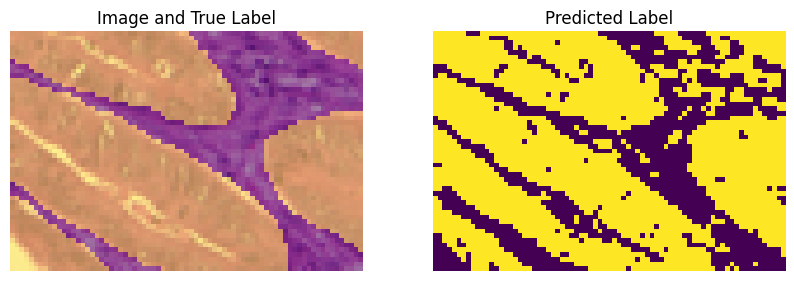

Plotting prediction on 76 epoch


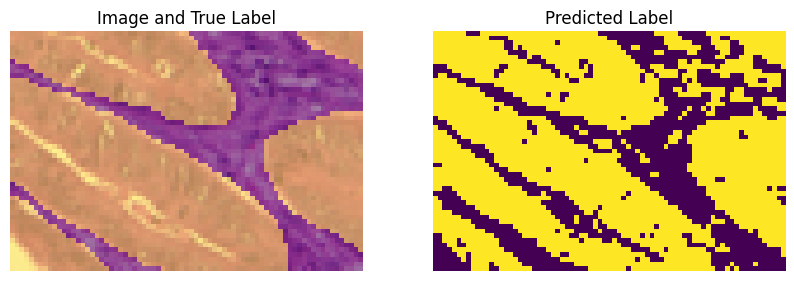

17/17 [==============================] - 8s 458ms/step - loss: 0.5594 - val_loss: 0.6666
Epoch 77/100
17/17 [==============================] - ETA: 0s - loss: 0.5738train_iou: 0.5610221550057947
test_iou: 0.5407021968003459
17/17 [==============================] - 11s 685ms/step - loss: 0.5738 - val_loss: 0.6743
Epoch 78/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5610 - val_loss: 0.6412
Epoch 79/100
17/17 [==============================] - ETA: 0s - loss: 0.5654train_iou: 0.4258490720385004
test_iou: 0.4503685060334828
17/17 [==============================] - 11s 685ms/step - loss: 0.5654 - val_loss: 0.6546
Epoch 80/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5576 - val_loss: 0.6403
Epoch 81/100
17/17 [==============================] - ETA: 0s - loss: 0.5623train_iou: 0.5353501775646016
test_iou: 0.5041255705917848
Plotting prediction on 81 epoch


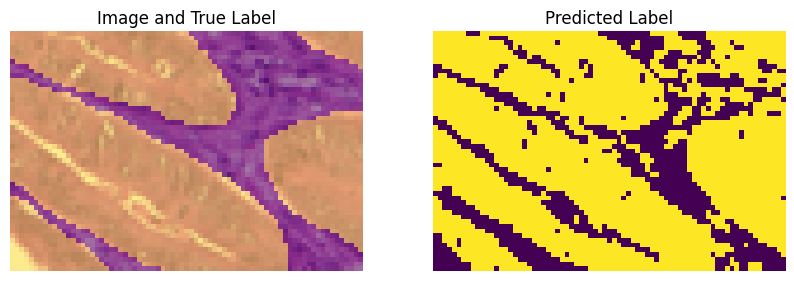

Plotting prediction on 81 epoch


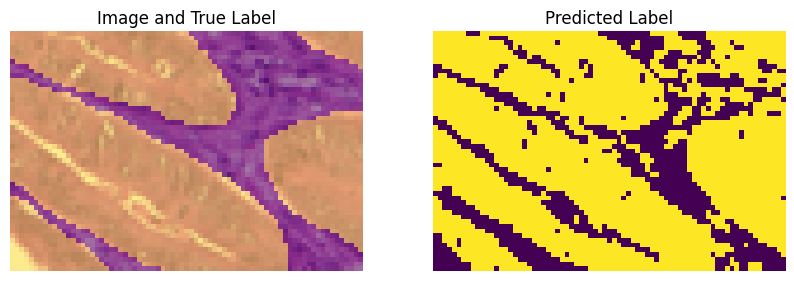

17/17 [==============================] - 12s 708ms/step - loss: 0.5623 - val_loss: 0.6376
Epoch 82/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5581 - val_loss: 0.6540
Epoch 83/100
17/17 [==============================] - ETA: 0s - loss: 0.5534train_iou: 0.5309251937309428
test_iou: 0.5021680043950788
17/17 [==============================] - 11s 685ms/step - loss: 0.5534 - val_loss: 0.6421
Epoch 84/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5578 - val_loss: 0.6361
Epoch 85/100
17/17 [==============================] - ETA: 0s - loss: 0.5550train_iou: 0.41739413326138425
test_iou: 0.37511703220178366
17/17 [==============================] - 11s 684ms/step - loss: 0.5550 - val_loss: 0.6891
Epoch 86/100
17/17 [==============================] - ETA: 0s - loss: 0.5503Plotting prediction on 86 epoch


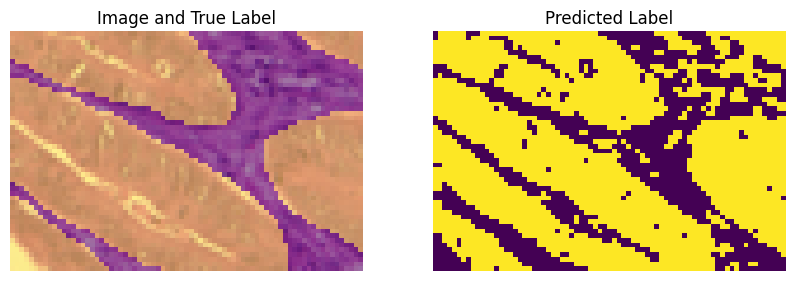

Plotting prediction on 86 epoch


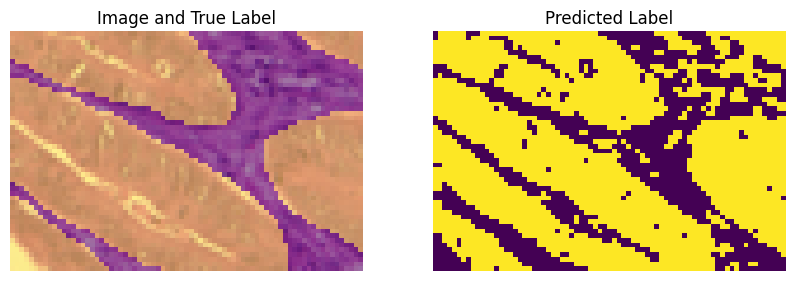

17/17 [==============================] - 8s 457ms/step - loss: 0.5503 - val_loss: 0.6484
Epoch 87/100
17/17 [==============================] - ETA: 0s - loss: 0.5478train_iou: 0.573729160675
test_iou: 0.5292759016876679
17/17 [==============================] - 11s 685ms/step - loss: 0.5478 - val_loss: 0.6308
Epoch 88/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5421 - val_loss: 0.6855
Epoch 89/100
17/17 [==============================] - ETA: 0s - loss: 0.5501train_iou: 0.5603937772407579
test_iou: 0.5035025850340723
17/17 [==============================] - 11s 685ms/step - loss: 0.5501 - val_loss: 0.6585
Epoch 90/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5418 - val_loss: 0.6689
Epoch 91/100
17/17 [==============================] - ETA: 0s - loss: 0.5453train_iou: 0.5671136786505563
test_iou: 0.5581206064964798
Plotting prediction on 91 epoch


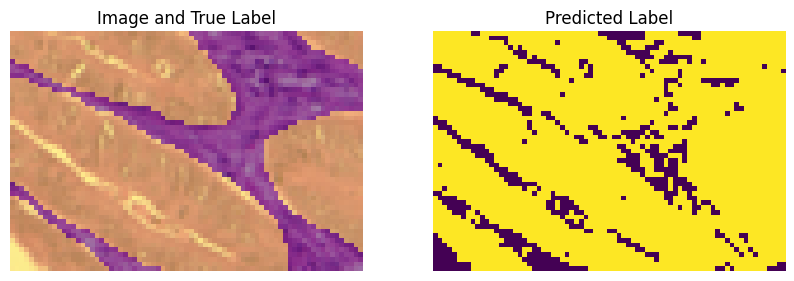

Plotting prediction on 91 epoch


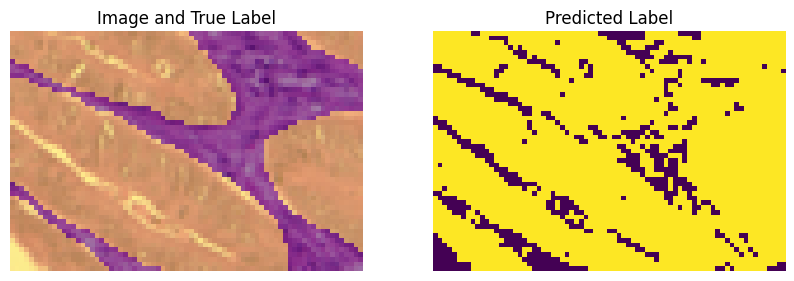

17/17 [==============================] - 12s 708ms/step - loss: 0.5453 - val_loss: 0.6595
Epoch 92/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5433 - val_loss: 0.6661
Epoch 93/100
17/17 [==============================] - ETA: 0s - loss: 0.5421train_iou: 0.5866114740210873
test_iou: 0.5702700170308626
17/17 [==============================] - 11s 685ms/step - loss: 0.5421 - val_loss: 0.7278
Epoch 94/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5466 - val_loss: 0.6398
Epoch 95/100
17/17 [==============================] - ETA: 0s - loss: 0.5324train_iou: 0.5587615290092284
test_iou: 0.5186089813091969
17/17 [==============================] - 11s 685ms/step - loss: 0.5324 - val_loss: 0.6242
Epoch 96/100
17/17 [==============================] - ETA: 0s - loss: 0.5412Plotting prediction on 96 epoch


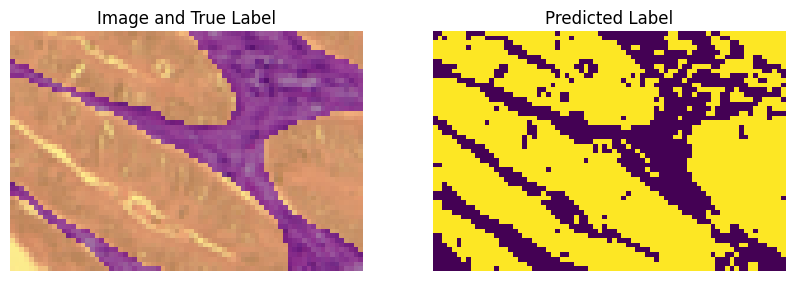

Plotting prediction on 96 epoch


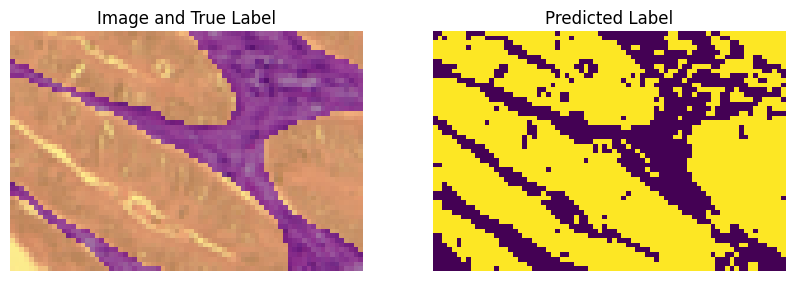

17/17 [==============================] - 8s 459ms/step - loss: 0.5412 - val_loss: 0.6553
Epoch 97/100
17/17 [==============================] - ETA: 0s - loss: 0.5478train_iou: 0.5640590635730082
test_iou: 0.5621237526441819
17/17 [==============================] - 11s 685ms/step - loss: 0.5478 - val_loss: 0.6929
Epoch 98/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5442 - val_loss: 0.6686
Epoch 99/100
17/17 [==============================] - ETA: 0s - loss: 0.5389train_iou: 0.47831793729276884
test_iou: 0.5079458588330559
17/17 [==============================] - 11s 686ms/step - loss: 0.5389 - val_loss: 0.6151
Epoch 100/100
17/17 [==============================] - 7s 435ms/step - loss: 0.5366 - val_loss: 0.6512


In [ ]:
model.fit(train_dataset, validation_data=test_dataset, 
          epochs=100, callbacks=[trainiou_cbk, testiou_cbk, evolution_cbk, evolution_cbk])

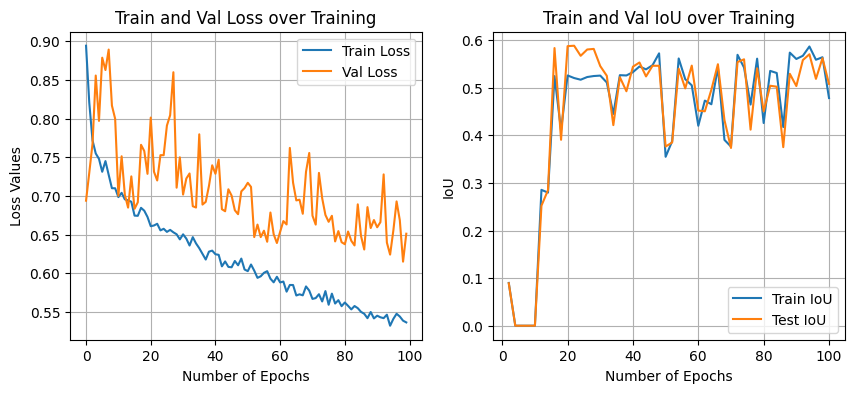

In [ ]:
path = "./gdrive/MyDrive/am220"
toSave = True; every = 2
fig, ax = plt.subplots(1, 2, figsize=(10, 4));
ax[0].plot(model.history.history['loss'], label='Train Loss');
ax[0].plot(model.history.history['val_loss'], label='Val Loss');
ax[0].grid();
ax[0].legend();
ax[0].set_xlabel("Number of Epochs");
ax[0].set_ylabel("Loss Values");
ax[0].set_title("Train and Val Loss over Training");
##plot the tran and val IOU
xlab = np.arange(1, len(model.history.history['train_iou'])+1)*every
ax[1].plot(xlab, model.history.history['train_iou'], label='Train IoU');
ax[1].plot(xlab, model.history.history['test_iou'], label='Test IoU');
ax[1].grid();
ax[1].legend();
ax[1].set_xlabel("Number of Epochs");
ax[1].set_ylabel("IoU");
ax[1].set_title("Train and Val IoU over Training");
if toSave:
  savepath = path + "/loss_trace_k15_B16_H64_epoch100_lr2e-4_N212-144-standardized.png"
  plt.savefig(savepath, dpi=200)

### Take one batch in the train set as sample
to see how the model predicts

In [ ]:
#take one sample
for X, y in train_dataset.take(3):
  pass

In [ ]:
##output of the model over this batch
output = model(X)

9


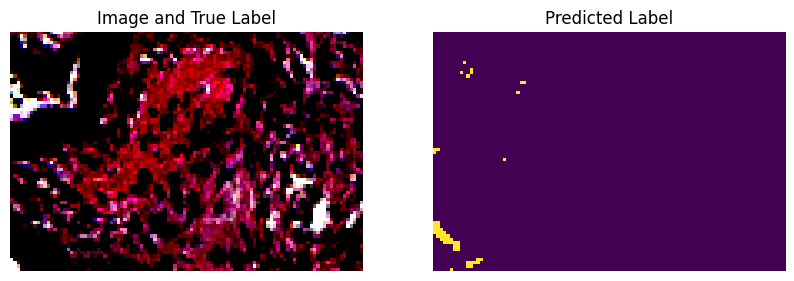

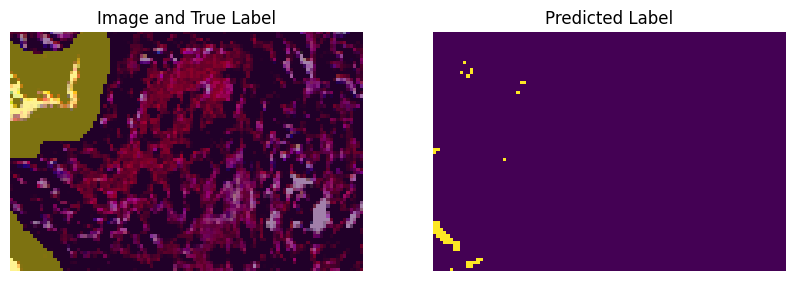

In [ ]:
##plot one picture of prediction 
index = np.random.randint(0, 16)
print(index)
y_pred = (output.numpy() > 0.5)*1
plot_result(y_pred[index], y[index].numpy(), X[index].numpy(), show_label=False)
plot_result(y_pred[index], y[index].numpy(), X[index].numpy())


### Compute and Print the Train Accuracy

In [ ]:
train_accuracy = avg_accuracy(model, train_dataset)
print("Train Accuracy: {}".format(train_accuracy))

Train Accuracy: 0.6194445889597976


### Compute and Print the Test Accuracy

In [ ]:
#test accuracy 
test_accuracy = avg_accuracy(model, test_dataset)
print("Test Accuracy: {}".format(test_accuracy))

Test Accuracy: 0.6382517688679246


### Compute and print the train and test IOU

In [ ]:
train_iou = avg_IoU(model, train_dataset)
print("Train IOU: {}".format(train_iou))

Train IOU: 0.5558386797263057


In [ ]:
test_iou = avg_IoU(model, test_dataset)
print("Test IOU: {}".format(test_iou))

Test IOU: 0.5956246125411214


### Compute and print the train and test DICE score

In [ ]:
train_dice = avg_DICE(model, train_dataset)
print("Train DICE: {}".format(train_dice))

Train DICE: 0.34883175853617887


In [ ]:
test_dice = avg_DICE(model, test_dataset)
print("Test DICE: {}".format(test_dice))

Test DICE: 0.37165443726245956


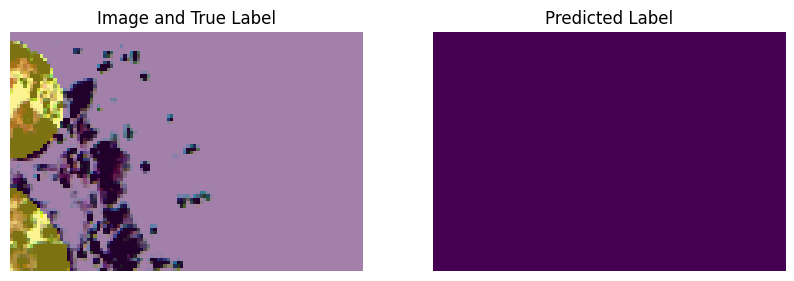

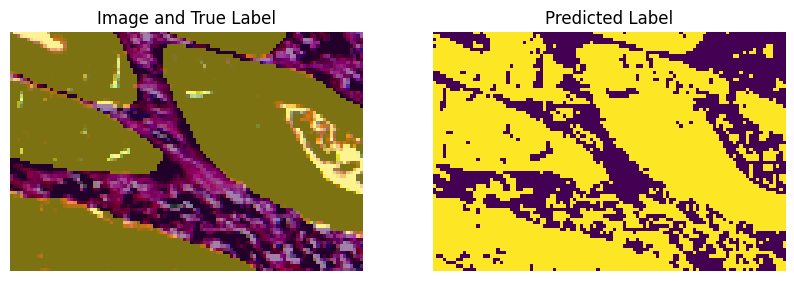

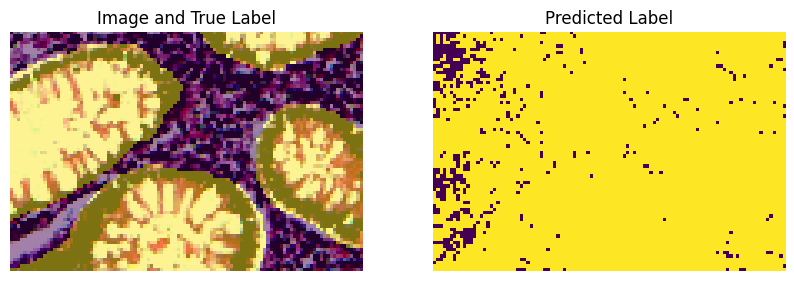

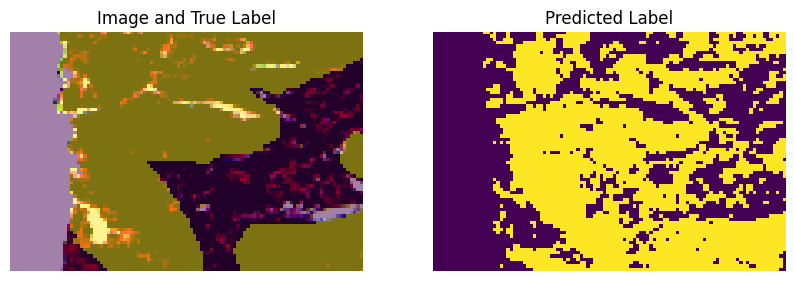

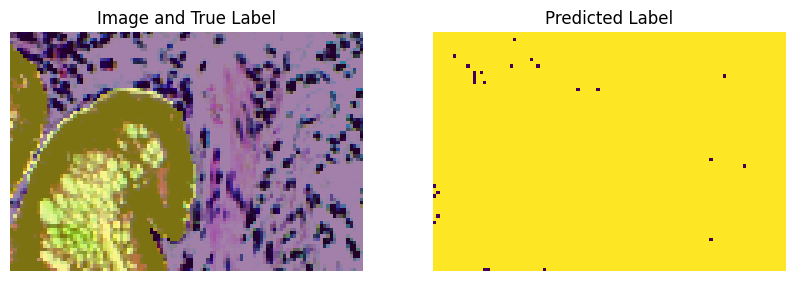

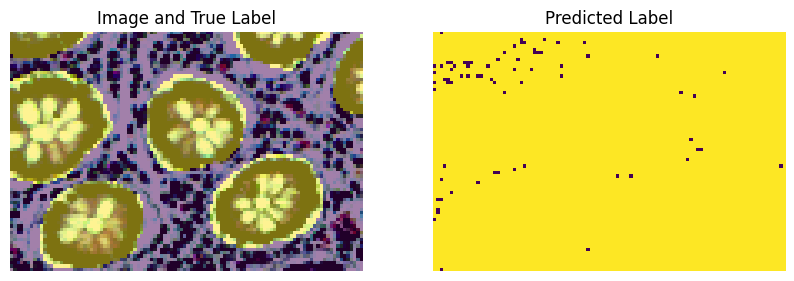

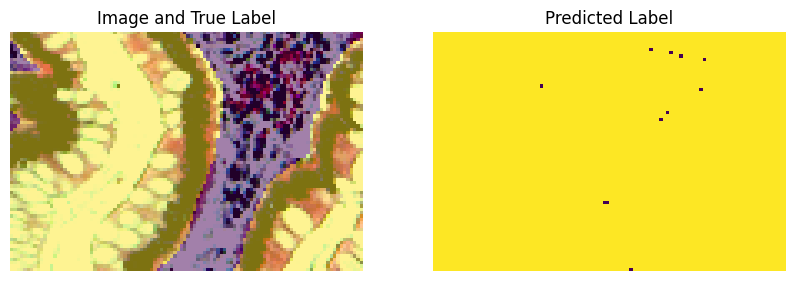

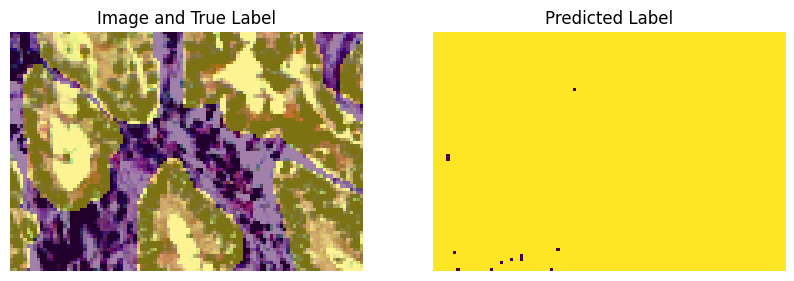

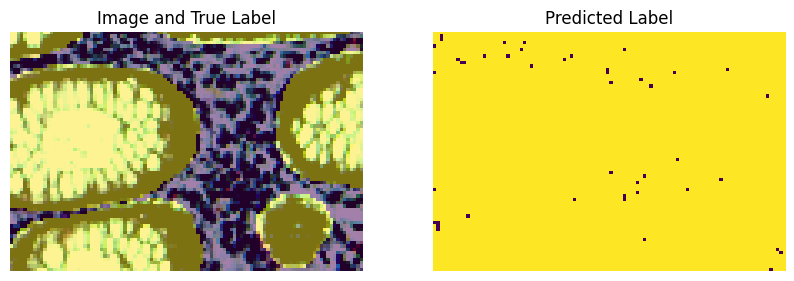

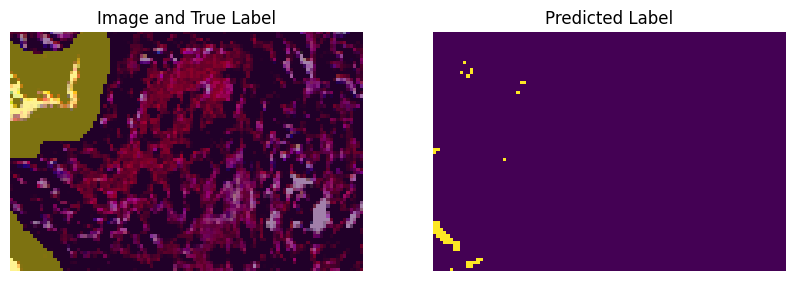

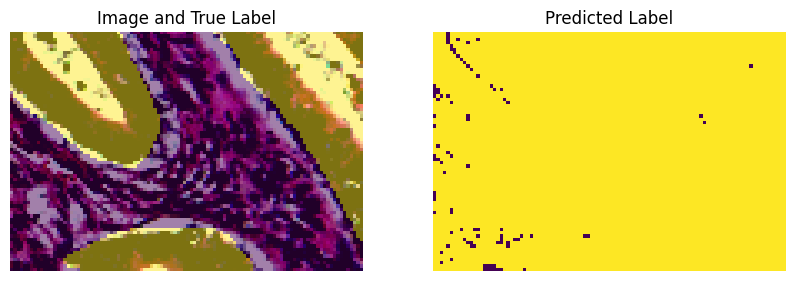

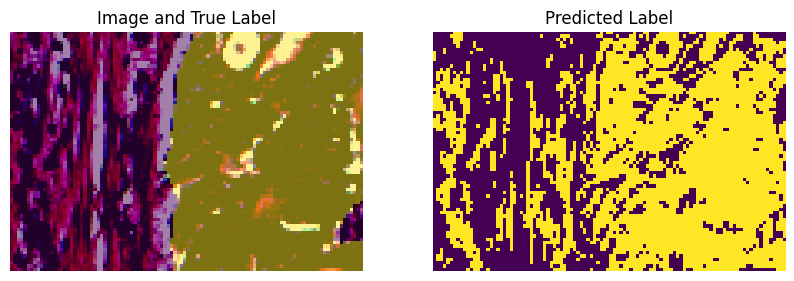

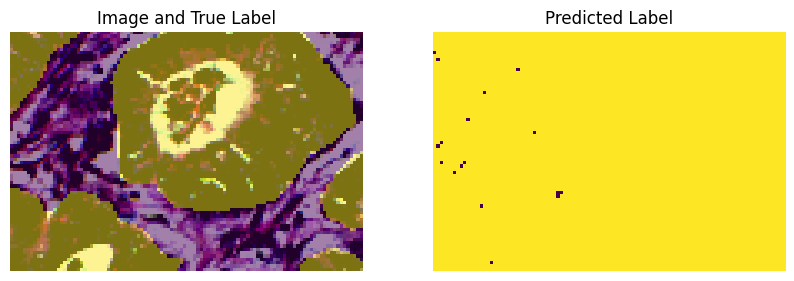

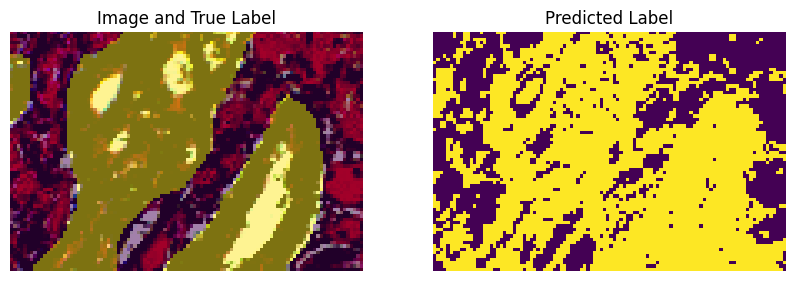

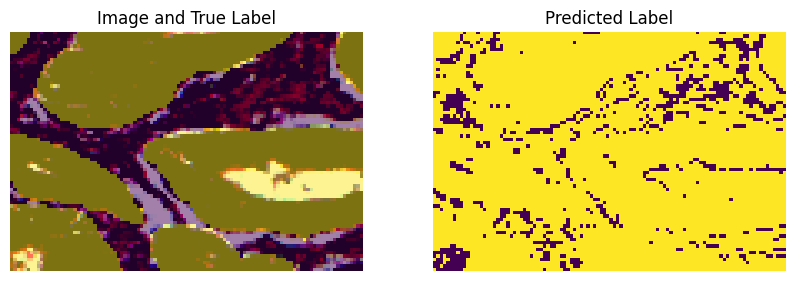

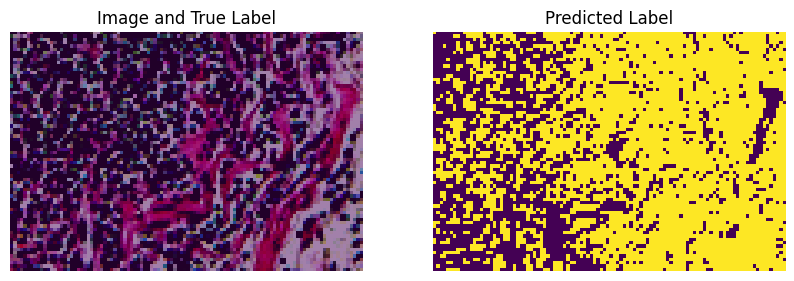

In [ ]:
path = "./gdrive/MyDrive/am220"
toSave = False
for i in range(16):
  savepath=None
  if toSave:
    savepath = path+"/train{}.png".format(i+1)
  plot_result(y_pred[i], y[i].numpy(), X[i].numpy(), savepath)

In [ ]:
for X, y in test_dataset.take(2):
  continue

In [ ]:
output = model(X)
y_pred = (output.numpy() > 0.5)*1

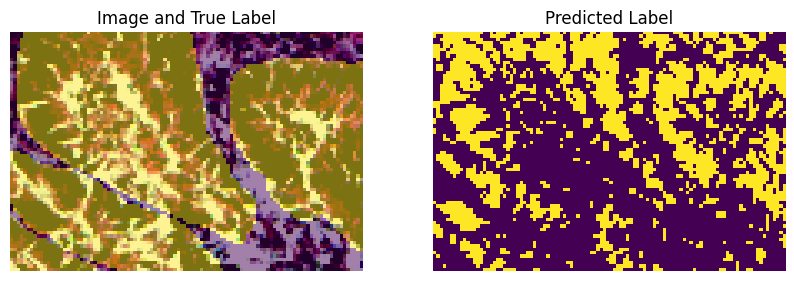

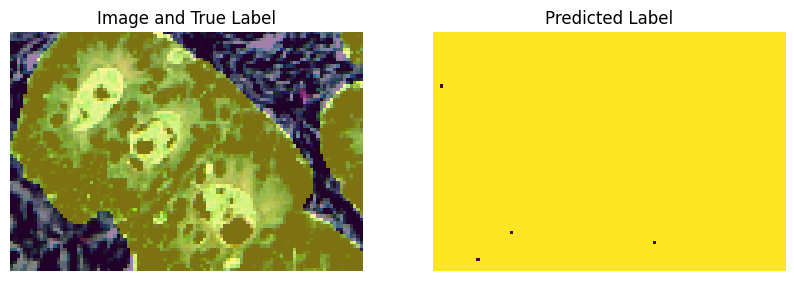

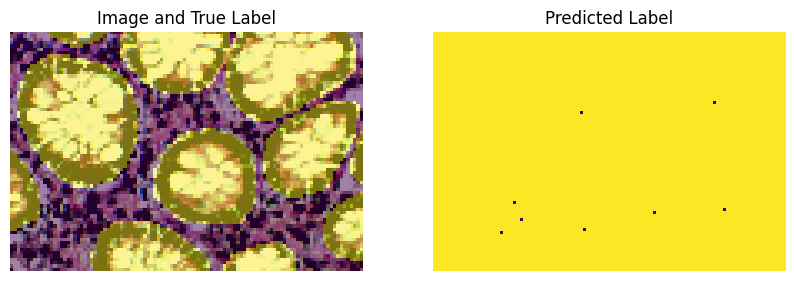

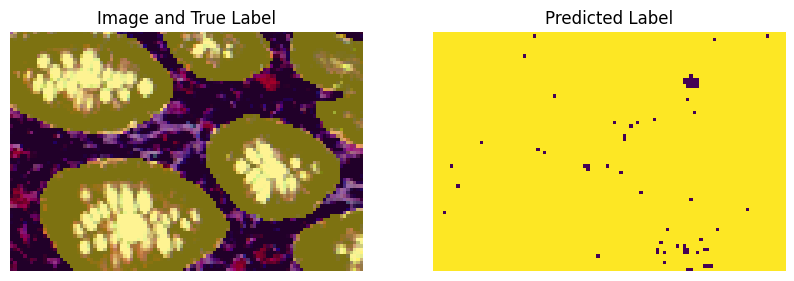

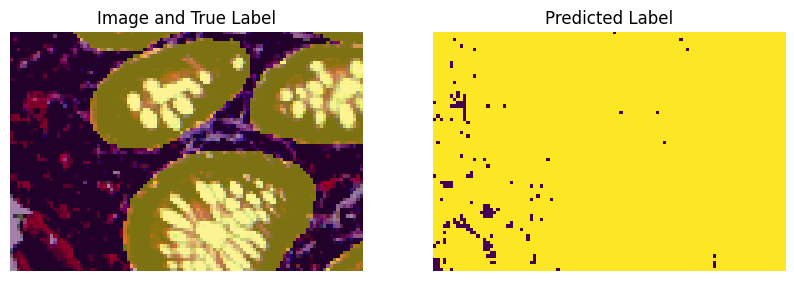

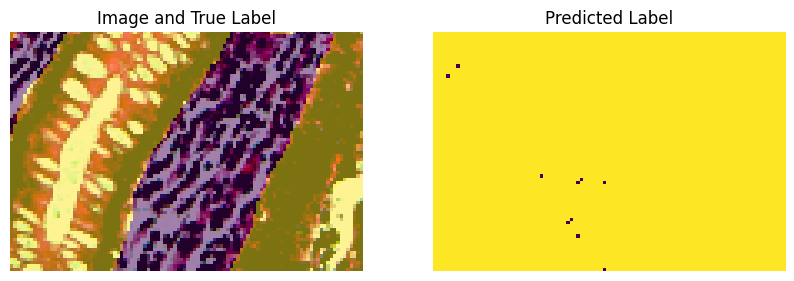

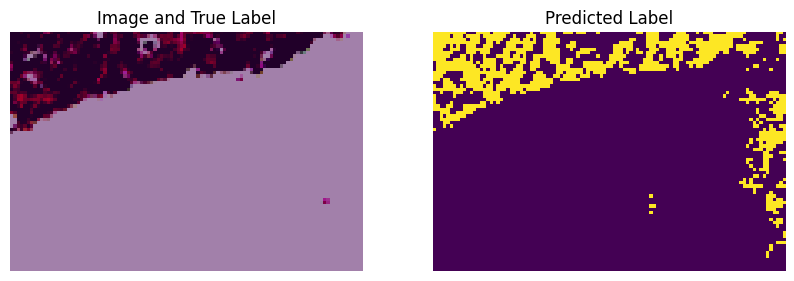

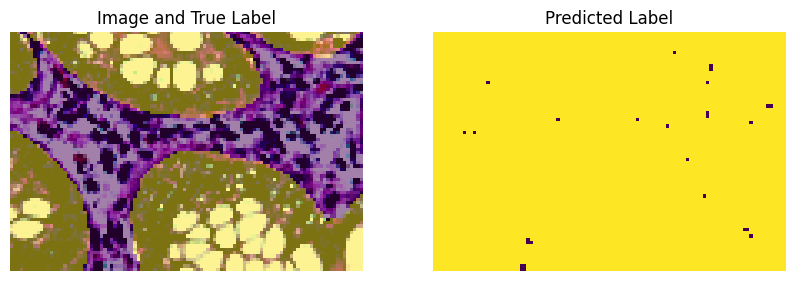

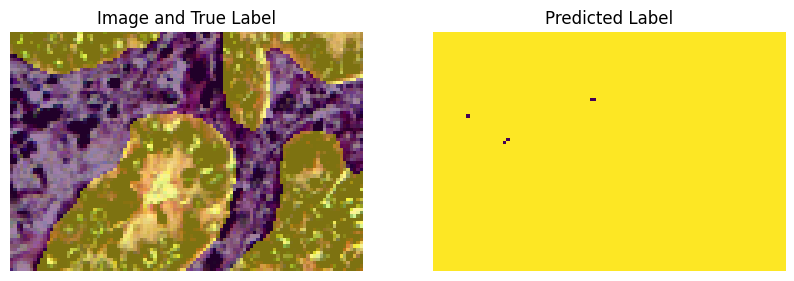

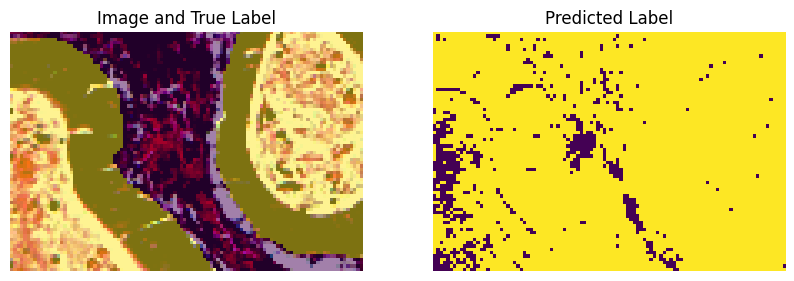

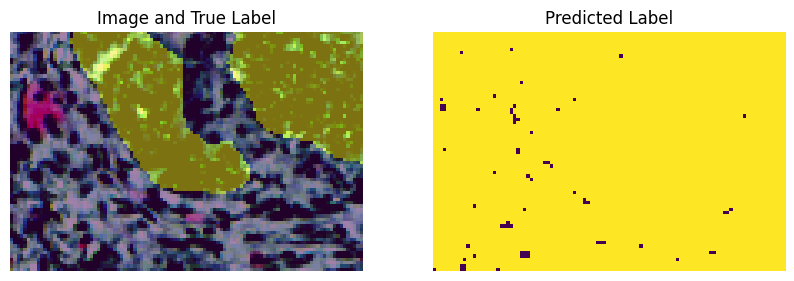

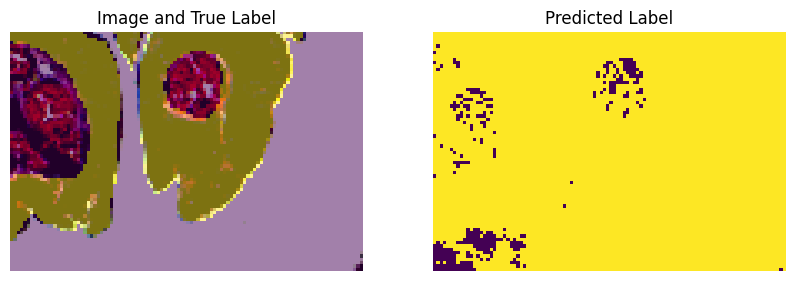

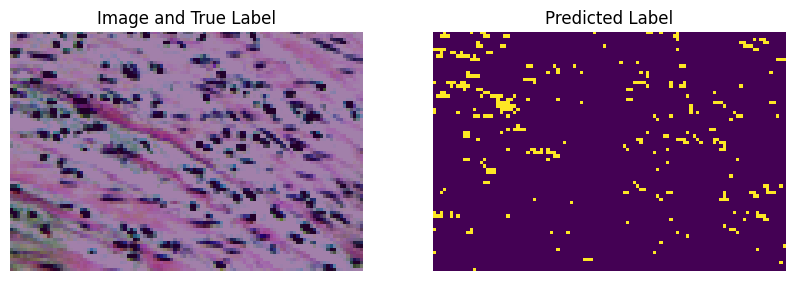

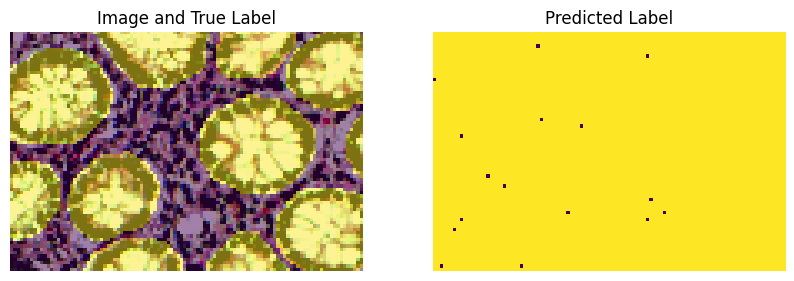

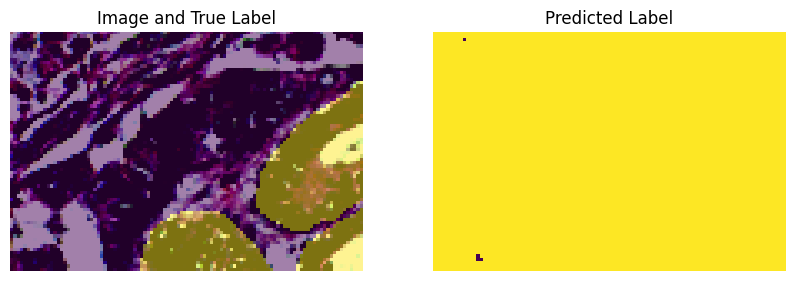

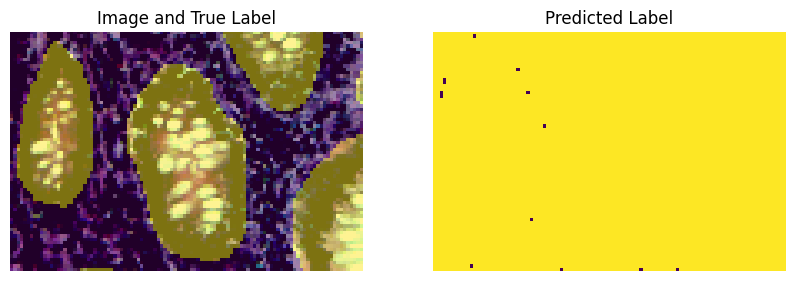

In [ ]:
path = "./gdrive/MyDrive/am220"
toSave = False
for i in range(16):
  savepath=None
  if toSave:
    savepath = path+"/val{}.png".format(i+1)
  plot_result(y_pred[i], y[i].numpy(), X[i].numpy(), savepath)